In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import make_h_combined, PC_axes, get_color_inds, name_best_ckpt
from tools_lnd import gen_trials_from_model_dir, take_names, get_T_inds


In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','supp','supp_IC_layout')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def stats_corr(X,y,num_perms = 10):
# Create linear regression object
    
    test_set_size = int(len(X)/10)

    r2 = [None]*num_perms
    mse = [None]*num_perms
    for perm in range(num_perms):

        regr = linear_model.LinearRegression()

        rand_order = np.random.permutation(len(X))

        y_train = y[rand_order[:-test_set_size]]
        X_train = X[rand_order[:-test_set_size], np.newaxis]

        y_test = y[rand_order[-test_set_size:]]
        X_test = X[rand_order[-test_set_size:], np.newaxis]

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)

        r2[perm] = r2_score(y_test, y_pred)
        mse[perm] = mean_squared_error(y_test, y_pred)
        
    return r2,mse

In [4]:
from adjustText import adjust_text
def plot_task_layout_PCA(h_combined_all,task_nums,figsize = 7,pcs = [0,1],color_set = []):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 16})
    ax1 = plt.subplot(1,1,1)
    if len(color_set)<1:
        color_inds, color_inds_nu = get_color_inds()
    else:
        color_inds_nu = color_set
    
    n_trials = len(h_combined_all)
    X_train = h_combined_all[0:n_trials:2,:]
    pca = PCA(n_components = 4)
    fp_pca = pca.fit(X_train)
    
    X_test = h_combined_all[1:n_trials:2,:]
    fp_pca = pca.transform(X_test)
    D_use = fp_pca[:,pcs]
    
    n_trials = int(len(X_test)/len(task_nums))
    
    together = []
    for t_num in range(len(task_nums)):
        c = color_inds_nu[task_nums[t_num]]
        trials_use = range(t_num*n_trials,(t_num+1)*n_trials)
        plt.plot(D_use[trials_use,0],D_use[trials_use,1],'o',c = c,alpha = .2,markersize = 10)
        rule = rules_dict['all'][task_nums[t_num]]
        _, rule_name, _, _ = take_names('fix1',rule)
#         plt.text(np.mean(D_use[trials_use,0])-.01,1.1*np.mean(D_use[trials_use,1]),
#                  rule_name,color = c,fontsize = 20,weight="bold")
        
        together.append((np.mean(D_use[trials_use,0]),np.mean(D_use[trials_use,1]),rule_name,c))
    
    texts = []
    for x, y, s, c in together:
        texts.append(plt.text(x, y, s, color = c, fontsize = 20, weight="bold"))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    PC_axes(ax1)
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='k', lw=1))

    
    task_list = [rules_dict['all'][x] for x in task_nums]
    
    if not os.path.exists(os.path.join(figpath,net_name)):
        os.makedirs(os.path.join(figpath,net_name))
    
    figname = 'task_layout.pdf'
    plt.savefig(os.path.join(figpath,save_net_name,figname),bbox_inches='tight')
    
    figname = 'task_layout.png'
    plt.savefig(os.path.join(figpath,save_net_name,figname))
    print(os.path.join(figpath,figname))
    
    plt.show()

In [5]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '0'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final/all'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [6]:
save_net_name = '_'.join((rnn_type,activation,w_init,seed))

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


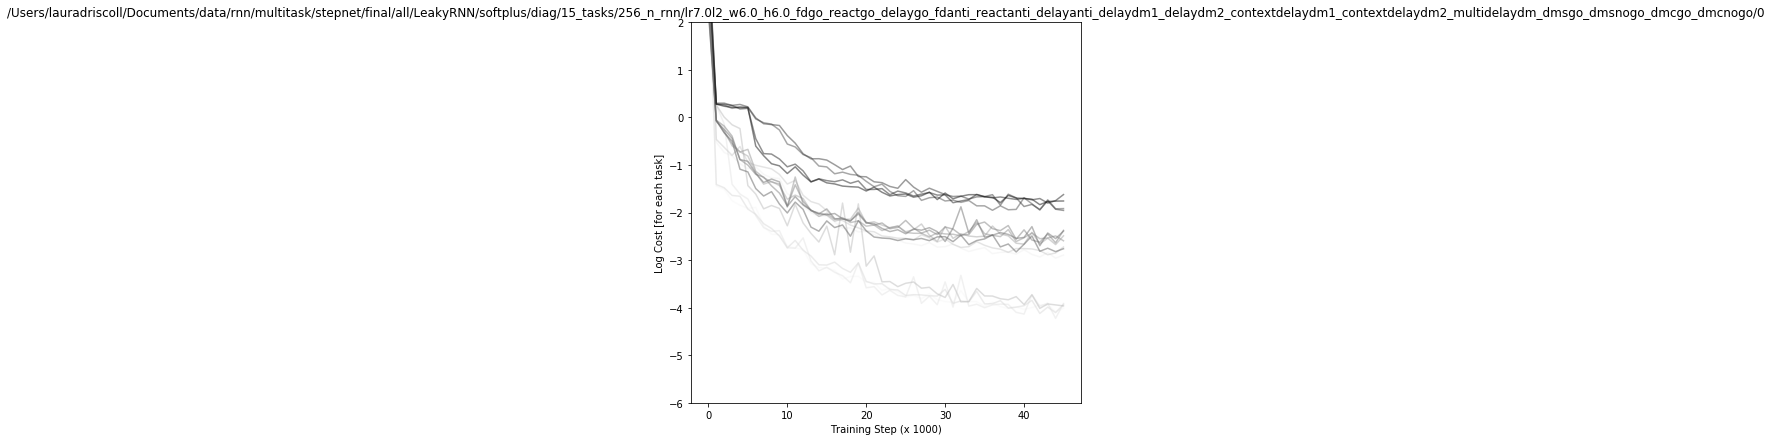

In [7]:
fig = plt.figure(figsize=(7, 7))
cmap=plt.get_cmap('Greys')

for r in range(len(rule_trains)):
        
    fname = os.path.join(m, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
        c = cmap((r+1)/(len(rule_trains)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+rule_trains[r]])
        plt.plot(x,'-',c = c,alpha = .5)
    
ax.set_xlabel('Training Step (x 1000)')
ax.set_ylabel('Log Cost [for each task]')
plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [8]:
from tools_lnd import same_stim_trial
def make_h_combined(model_dir_all,tasks,trial_set,epoch,ind = -1,ckpt_n_dir = []):

    h_combined = []

    model = Model(model_dir_all)
    with tf.Session() as sess:

        rule = 'delaygo'
        if len(ckpt_n_dir)>0:
            model.saver.restore(sess,ckpt_n_dir)
        else:
            model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial_master = generate_trials(rule, hparams, mode='random', batch_size = 100,noise_on=True)

        #get size of relevant variables to init mats
        n_inputs = np.shape(trial_master.x)[2]
        N = np.shape(params[0])[1]
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]
        n_stim_dims = np.shape(trial_master.x)[2]-len(hparams['rules'])


        # trial_master = generate_trials(rule, hparams, mode='random', batch_size = 100,noise_on=True)
        T_inds = get_T_inds(trial_master,epoch)

        for r in range(len(tasks)):
            r_all_tasks_ind = tasks[r]


            trial = same_stim_trial(trial_master, r_all_tasks_ind)

            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            h_epoch = h_tf[T_inds,:,:]
            h_temp = h_epoch[ind,trial_set,:]

            #concatenate activity states across tasks
            if h_combined == []:
                h_combined = h_temp
            else:
                h_combined = np.concatenate((h_combined, h_temp), axis=0)

    return h_combined

In [9]:
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

ckpt_n_dir = []
trial_set = range(80)
task_nums = range(15) # all tasks
color_set = ['dodgerblue','turquoise','dodgerblue',
             'r','gold','r',
             'darkslategray','darkslategray','darkslategray','darkslategray','darkslategray',
             'mediumaquamarine','orange','mediumaquamarine','orange']
batch_size = len(trial_set)
# h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1')
# plot_task_layout_PCA(h_combined_fix,task_nums,figsize = 7,color_set = color_set,pcs = [0,1])

In [10]:
def make_dst_mat(X):
    X = np.squeeze(X).astype(np.float64)
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])
    return dst

In [11]:
from tools_lnd import angle_between
def make_angle_mat(X):
    X = np.squeeze(X).astype(np.float64)

    theta_mat = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        v1 = X[xi,:]
        for yi in range(np.shape(X)[0]):
            v2 = X[yi,:]
            theta_mat[xi,yi] = angle_between(v1, v2)
            
    return theta_mat

In [12]:
task_labels = {}
task_labels['all'] = range(15)
task_labels['Category Motif'] = [13, 14]
# task_labels['Decision Motif'] = [10,9]
task_labels['Different Motifs'] = [3,1]

def make_sub_mat(D_concat,T_concat,motif_grp_concat,D_mat,T_mat,labels,color_set = color_set):
    
    D_sub_mat = D_mat[labels,:]
    D_sub_mat = D_sub_mat[:,labels]
    D_sub_mat = np.tril(D_sub_mat,k = -1)
    
    T_sub_mat = T_mat[labels,:]
    T_sub_mat = T_sub_mat[:,labels]
    T_sub_mat = np.tril(T_sub_mat,k = -1)
    
    color_mat = np.matlib.repmat(color_set, len(color_set),1)
    same_motif = (color_mat == color_mat.T)
    motif_grp = same_motif[labels,:]
    motif_grp = motif_grp[:,labels]
    motif_grp = np.tril(motif_grp,k = -1)
    
    if len(D_concat)==0:
        D_concat = D_sub_mat[D_sub_mat>0][:,np.newaxis]
        T_concat = T_sub_mat[D_sub_mat>0][:,np.newaxis]
        motif_grp_concat = motif_grp[D_sub_mat>0][:,np.newaxis]
    else:  
        D_concat = np.concatenate((D_concat,D_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
        T_concat = np.concatenate((T_concat,T_sub_mat[D_sub_mat>0][:,np.newaxis]),axis = 1)
        motif_grp_concat = np.concatenate((motif_grp_concat,motif_grp[D_sub_mat>0][:,np.newaxis]),axis = 1)
    return D_concat,T_concat,motif_grp_concat

In [14]:
task_nums = range(15) # all tasks
trial_set = range(0,80,10)
h_combined_stim = make_h_combined(m,task_nums,trial_set,'stim1',ind = 1)
h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1',ind = -1)
h_stim_diff = h_combined_stim - h_combined_fix
theta_mat = make_angle_mat(h_stim_diff)
dst_fix = make_dst_mat(h_combined_fix)

figsize = 7
fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 20})
ax1 = plt.subplot(1,1,1)

D_concat = {}
T_concat = {}
motif_grp_concat = {}
for k in task_labels.keys():
    D_concat[k],T_concat[k],motif_grp_concat[k] = [],[],[]

batch_size = len(trial_set)
for xi in range(batch_size):
    
    dst_fix_stim_type = dst_fix[xi:len(dst_fix):batch_size,:]
    dst_fix_stim_type = dst_fix_stim_type[:,xi:len(dst_fix):batch_size]
    
    theta_mat_stim_type = theta_mat[xi:len(dst_fix):batch_size,:]
    theta_mat_stim_type = theta_mat_stim_type[:,xi:len(dst_fix):batch_size]
    
    for k in task_labels.keys():
        D_concat[k],T_concat[k],motif_grp_concat[k] = make_sub_mat(D_concat[k],T_concat[k],motif_grp_concat[k],
                                                                dst_fix_stim_type,theta_mat_stim_type,
                                                                task_labels[k],color_set = color_set)
    
for k in task_labels.keys():
    if k=='all':
        plt.scatter(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),#,s=30,
                 c = 'k',alpha = .5,s = (100*motif_grp_concat[k][:,0]+5))
    else:
        plt.plot(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),'ok',markerfacecolor = 'none',
                 markersize = 25,alpha = 1,label = k,linewidth = 5)
        plt.text(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),k,fontweight = 'bold')

# plt.xlim([.1,3])
# plt.ylim([.4,1.5])
# plt.legend(loc = 'lower right')
plt.xlabel('Euc. Dist. btwn Pairs of Tasks \n for Stim Period Initial Conds.')
# ax1.set_yticks([np.pi*(x/180) for x in range(30,70,10)])
# ax1.set_yticklabels(range(30,70,10))
plt.ylabel('Av. Angle btwn Pairs of Tasks for \n Single Timestep Stim Resp.(deg)')
# ax1.spines['left'].set_bounds(np.pi*(30/180), np.pi*(60/180))
# ax1.spines['bottom'].set_bounds(.5, 1.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(False)

if not os.path.exists(os.path.join(figpath,save_net_name)):
    os.makedirs(os.path.join(figpath,save_net_name))

figname = 'theta_v_dst.pdf'
plt.savefig(os.path.join(figpath,save_net_name,figname),bbox_inches='tight')

figname = 'theta_v_dst.png'
plt.savefig(os.path.join(figpath,save_net_name,figname))
print(os.path.join(figpath,figname))
    
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


TypeError: only size-1 arrays can be converted to Python scalars

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 504x504 with 1 Axes>

In [27]:
k = 'all'
D_concat,T_concat,motif_grp_concat = make_sub_mat([],[],[],dst_fix_stim_type,theta_mat_stim_type,
                                                  task_labels[k],color_set = color_set)

X = np.mean(D_concat,axis = 1)
y = np.mean(T_concat,axis = 1)

r2,mse = stats_corr(X,y,num_perms = 1000)

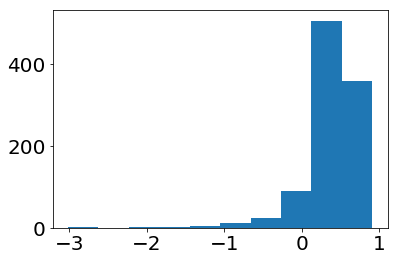

In [28]:
plt.hist(r2)
plt.show()

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_t

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


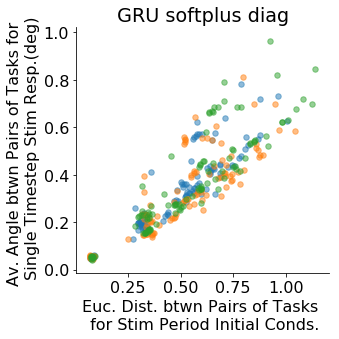

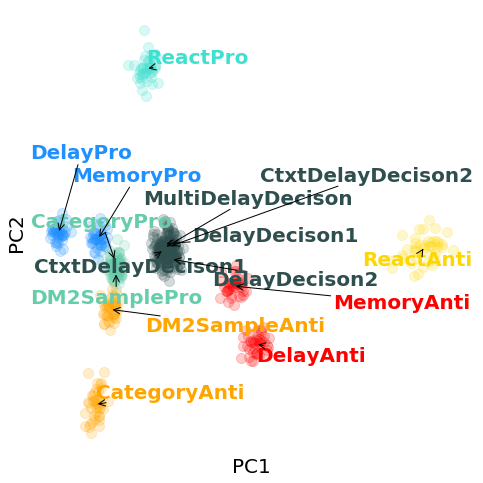

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_co

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_co

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_co

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_co

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_co

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/soft

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


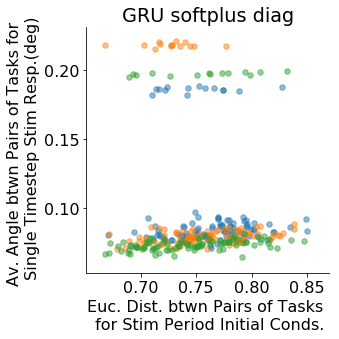

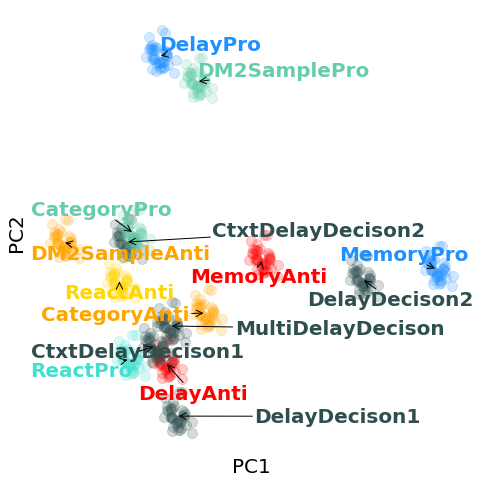

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/rand

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


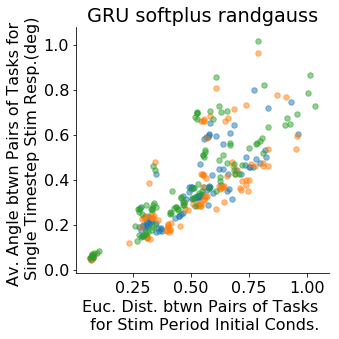

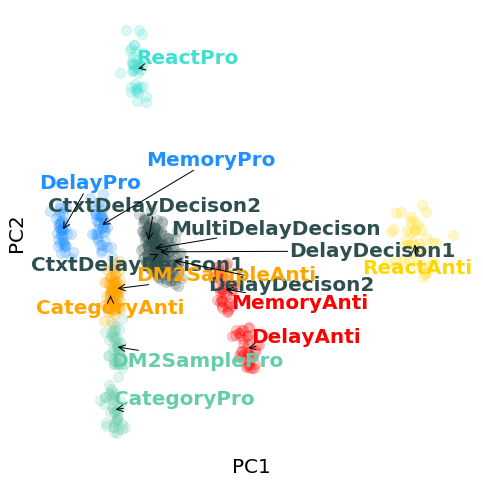

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_d

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_d

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_d

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_d

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_d

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


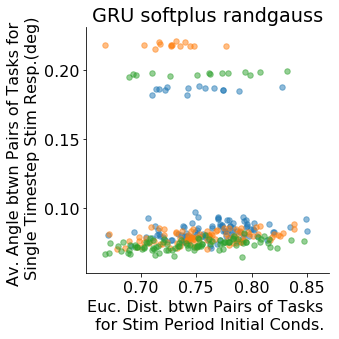

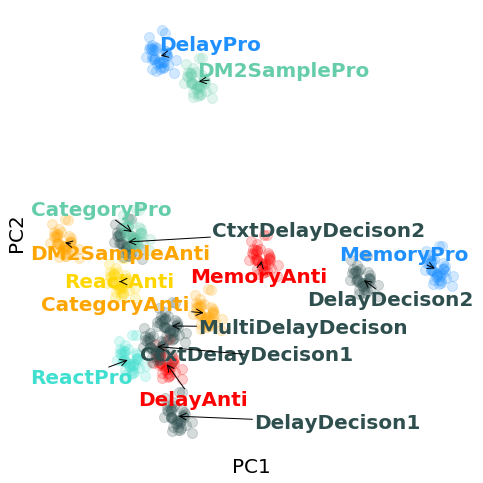

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_cont

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_cont

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_cont

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_cont

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_cont

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


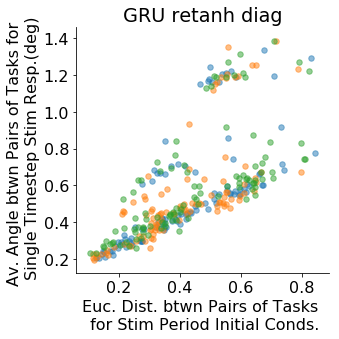

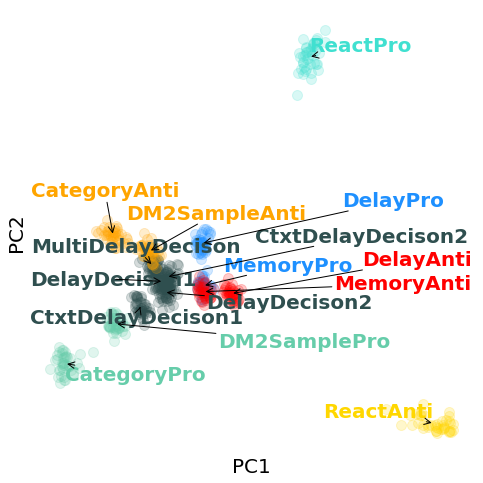

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contex

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


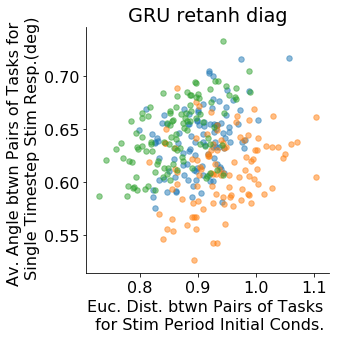

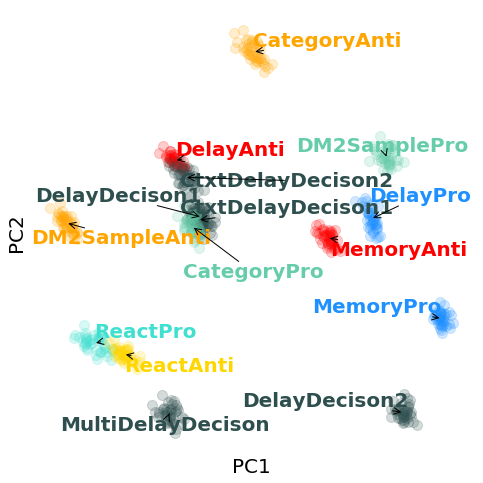

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgaus

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


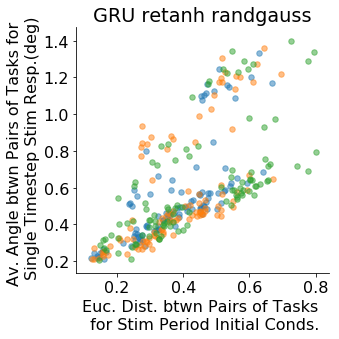

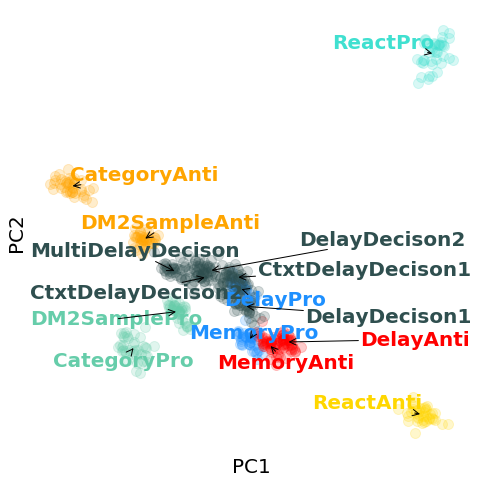

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delay

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delay

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delay

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delay

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delay

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/r

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


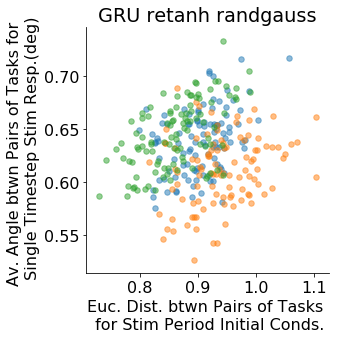

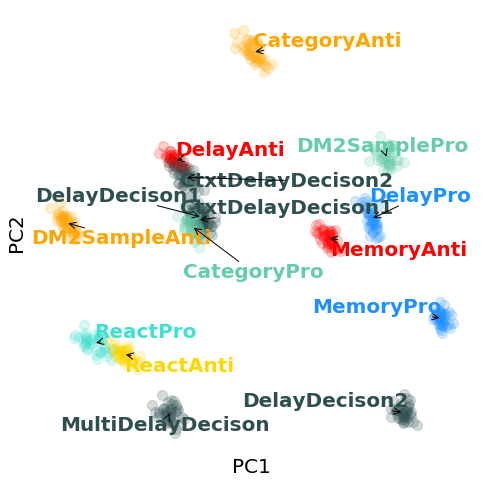

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


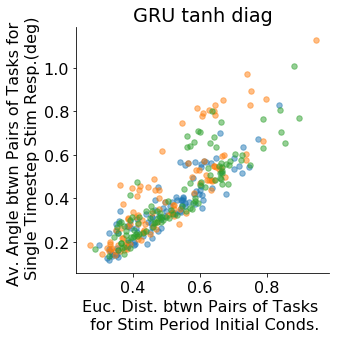

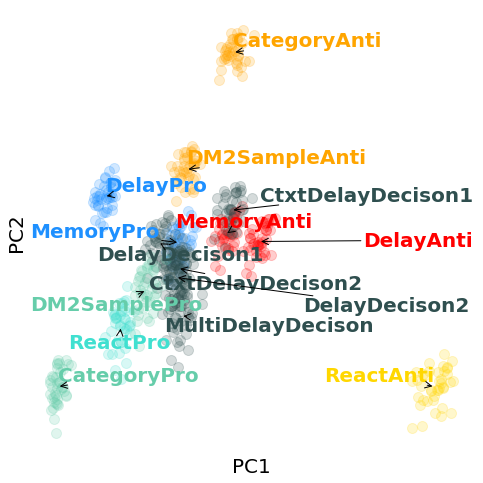

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/dia

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


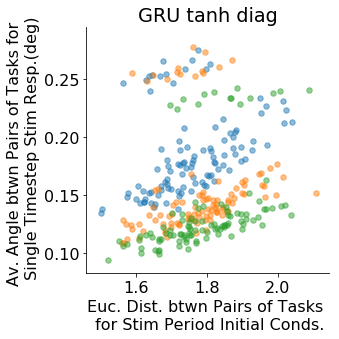

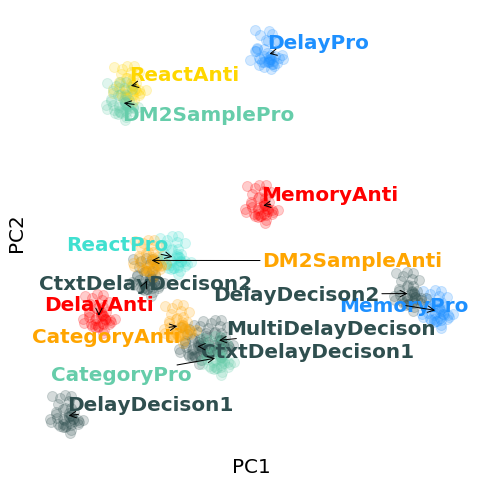

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


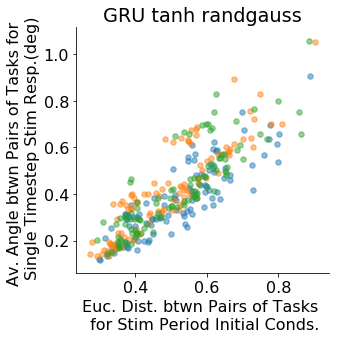

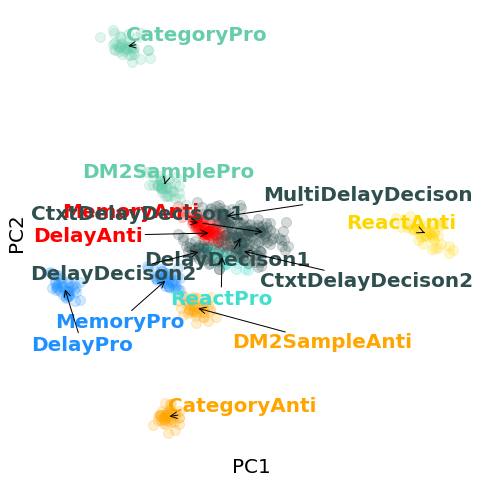

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tan

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/GRU/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


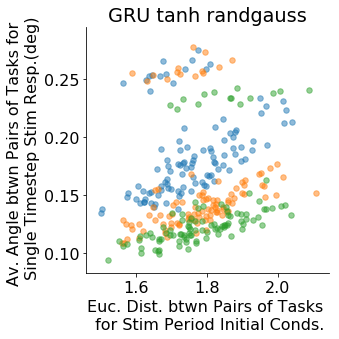

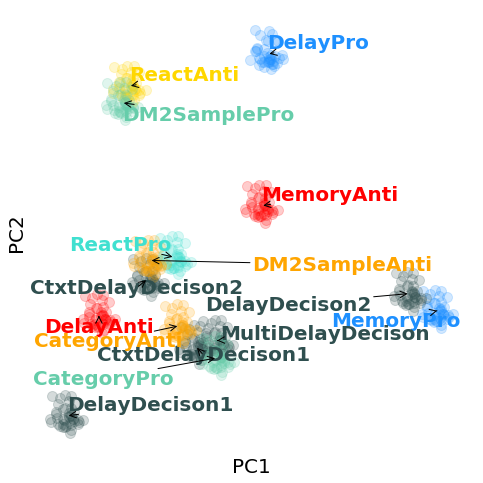

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


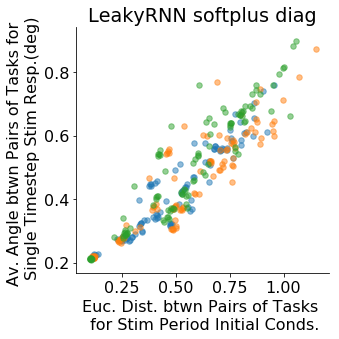

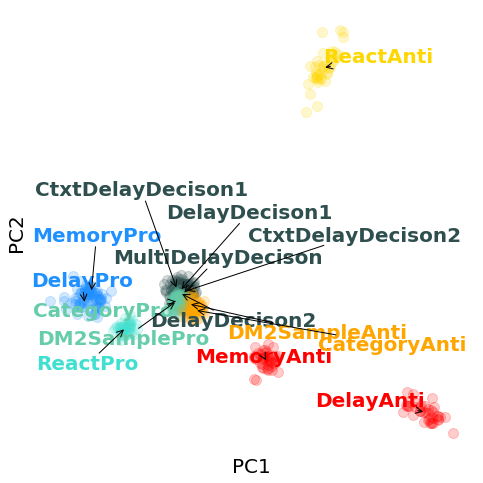

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multi

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


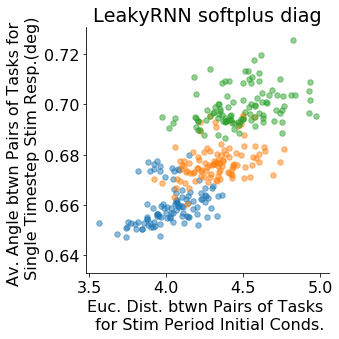

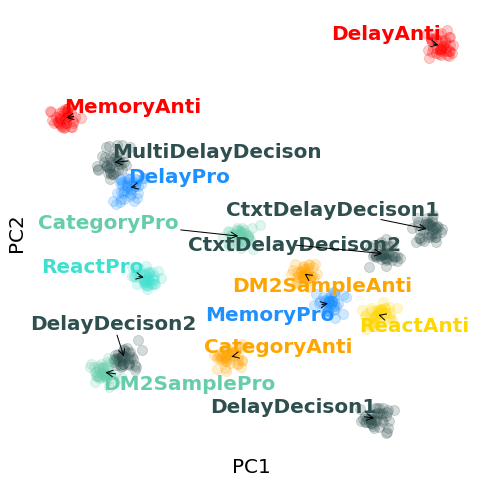

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidela

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


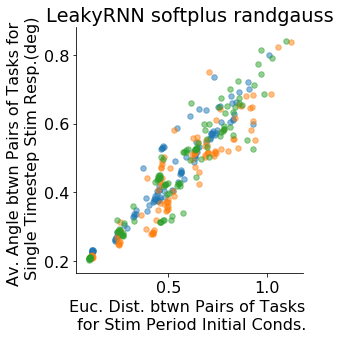

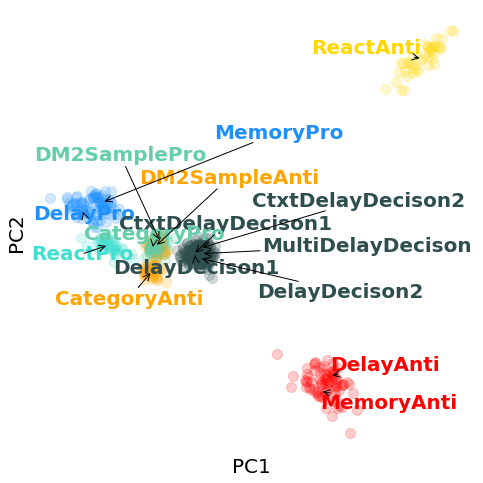

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdela

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


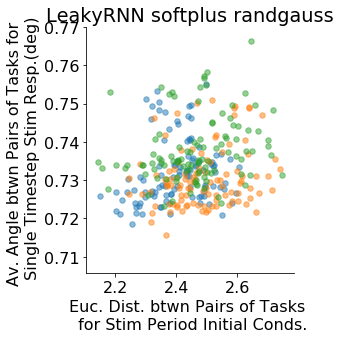

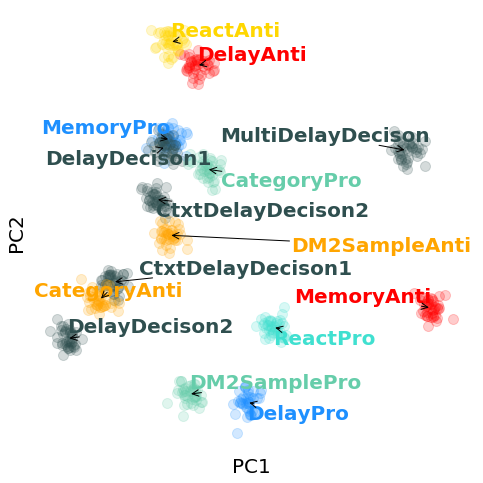

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsn

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


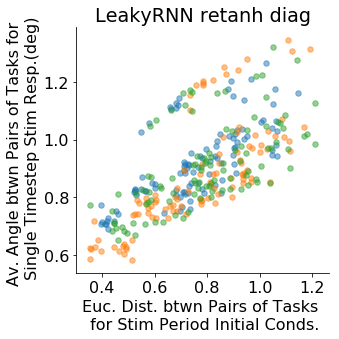

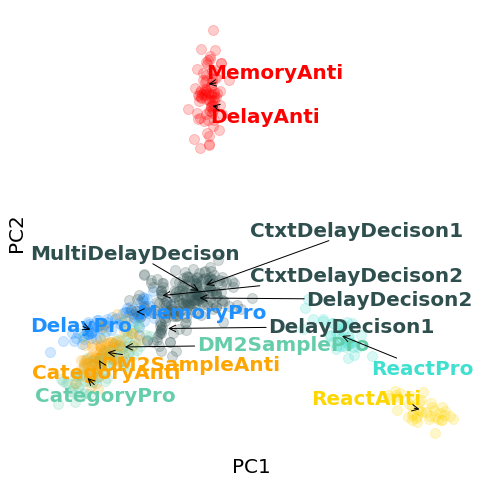

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidela

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


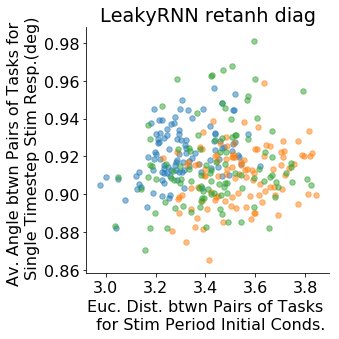

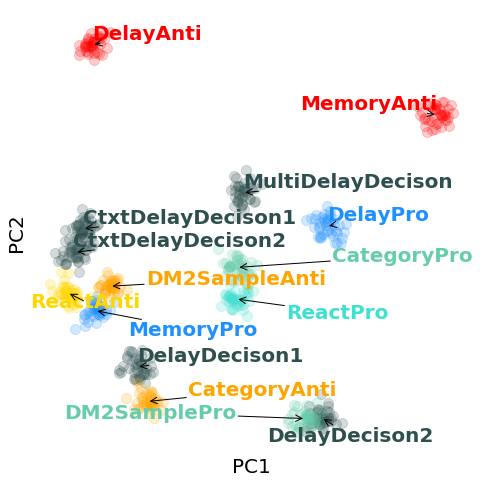

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


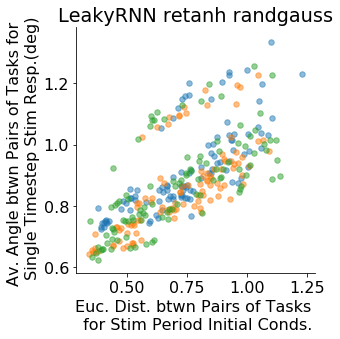

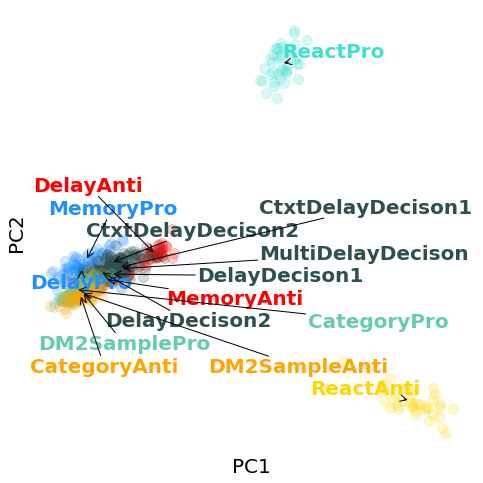

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


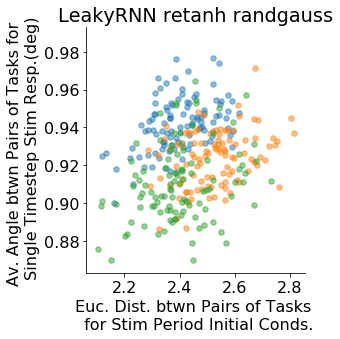

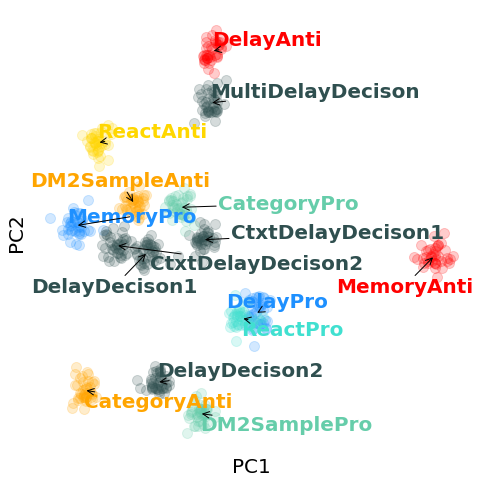

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


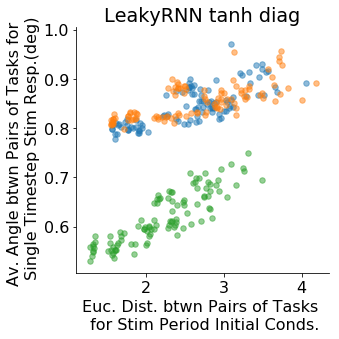

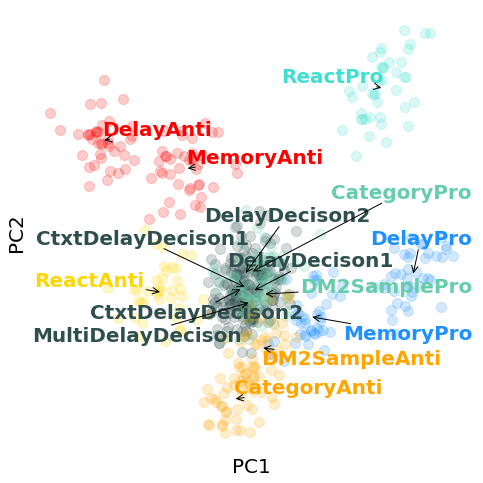

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


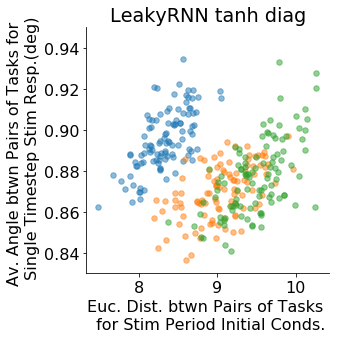

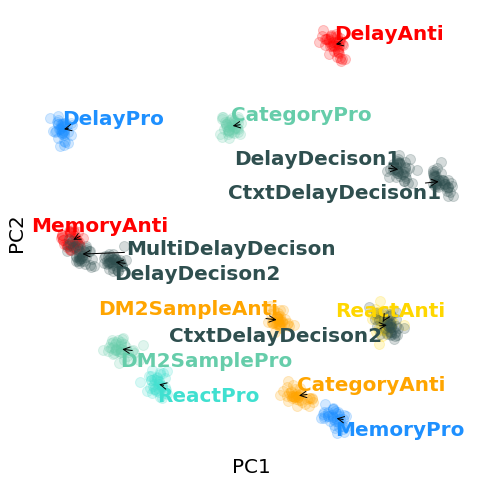

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsg

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


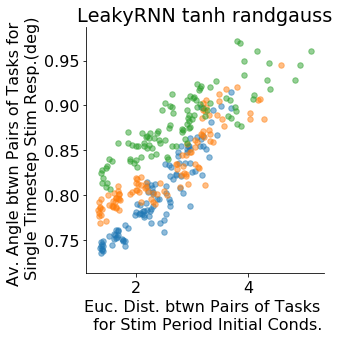

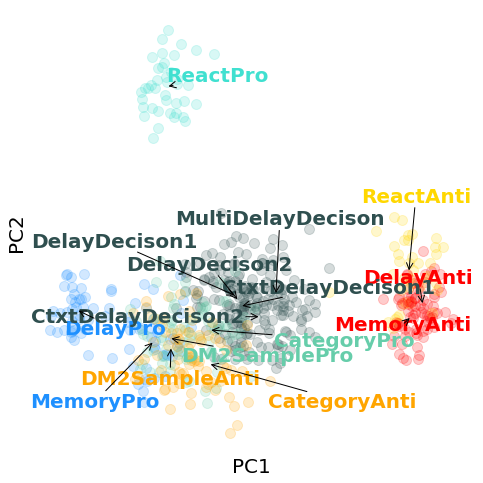

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/theta_v_dst.png
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_mul

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/untrained/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
fix1
/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v4_figs/paper_figs/supp/supp_IC_layout/task_layout.png


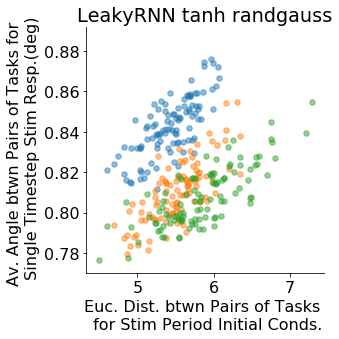

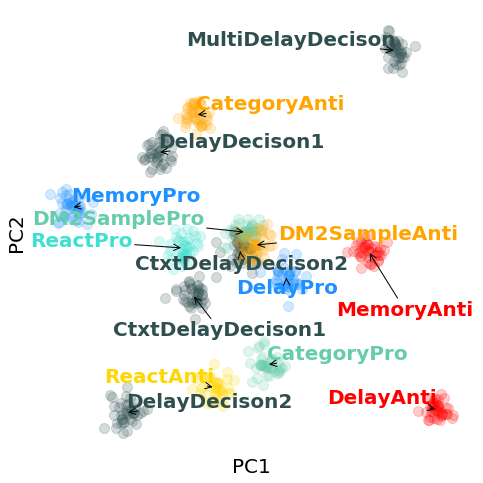

In [43]:
from sklearn.metrics import r2_score
task_nums = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19] # all tasks
trial_set = range(0,80,10)

rnn_type_set = ['GRU','LeakyRNN',]
activation_set = ['softplus','retanh','tanh']
w_init_set = ['diag','randgauss']
data_folder_set = ['lr','untrained',]
seed_set = [0,1,2]
data_folder_all = 'data/rnn/multitask/stepnet/'
r2 = {}

ckpt_n_dir = []
trial_set = range(80)
task_nums = range(15) # all tasks
color_set = ['dodgerblue','turquoise','dodgerblue',
             'r','gold','r',
             'darkslategray','darkslategray','darkslategray','darkslategray','darkslategray',
             'mediumaquamarine','orange','mediumaquamarine','orange']
batch_size = len(trial_set)

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]
                
                save_net_name = '_'.join((rnn_type,activation,w_init,data_folder))
                save_net_name_fancy = ' '.join((rnn_type,activation,w_init))
                
                figsize = 5
                fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
                plt.rcParams.update({'font.size': 16})
                ax1 = plt.subplot(1,1,1)

                for seed in seed_set:

                    m = os.path.join(p,data_folder_all,data_folder,rnn_type,activation,w_init,
                                     n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,str(seed))
                    
                    h_combined_stim = make_h_combined(m,task_nums,trial_set,'stim1',ind = 1)
                    h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1',ind = -1)
                    h_stim_diff = h_combined_stim - h_combined_fix
                    theta_mat = make_angle_mat(h_stim_diff)
                    dst_fix = make_dst_mat(h_combined_fix)

                    D_concat = {}
                    T_concat = {}
                    motif_grp_concat = {}
                    for k in task_labels.keys():
                        D_concat[k],T_concat[k],motif_grp_concat[k] = [],[],[]

                    batch_size = len(trial_set)
                    for xi in range(batch_size):

                        dst_fix_stim_type = dst_fix[xi:len(dst_fix):batch_size,:]
                        dst_fix_stim_type = dst_fix_stim_type[:,xi:len(dst_fix):batch_size]

                        theta_mat_stim_type = theta_mat[xi:len(dst_fix):batch_size,:]
                        theta_mat_stim_type = theta_mat_stim_type[:,xi:len(dst_fix):batch_size]

                        for k in task_labels.keys():
                            D_concat[k],T_concat[k],motif_grp_concat[k] = make_sub_mat(D_concat[k],T_concat[k],motif_grp_concat[k],
                                                                                    dst_fix_stim_type,theta_mat_stim_type,
                                                                                    task_labels[k],color_set = color_set)

                    for k in task_labels.keys():
                        if k=='all':
                            plt.scatter(np.mean(D_concat[k],axis = 1),np.mean(T_concat[k],axis = 1),30,
                                     alpha = .5) #s = (100*motif_grp_concat[k][:,0]+5)
                            
                plt.title(save_net_name_fancy)
                
                # plt.xlim([.1,3])
                # plt.ylim([.4,1.5])
                # plt.legend(loc = 'lower right')
                plt.xlabel('Euc. Dist. btwn Pairs of Tasks \n for Stim Period Initial Conds.')
                # ax1.set_yticks([np.pi*(x/180) for x in range(30,70,10)])
                # ax1.set_yticklabels(range(30,70,10))
                plt.ylabel('Av. Angle btwn Pairs of Tasks for \n Single Timestep Stim Resp.(deg)')
                # ax1.spines['left'].set_bounds(np.pi*(30/180), np.pi*(60/180))
                # ax1.spines['bottom'].set_bounds(.5, 1.5)
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)
                # ax1.spines['bottom'].set_visible(False)
                # ax1.spines['left'].set_visible(False)

                if not os.path.exists(os.path.join(figpath,save_net_name)):
                    os.makedirs(os.path.join(figpath,save_net_name))

                figname = 'theta_v_dst.pdf'
                plt.savefig(os.path.join(figpath,save_net_name,figname),bbox_inches='tight')

                figname = 'theta_v_dst.png'
                plt.savefig(os.path.join(figpath,save_net_name,figname))
                print(os.path.join(figpath,figname))
                
                h_combined_fix = make_h_combined(m,task_nums,trial_set,'fix1')
                plot_task_layout_PCA(h_combined_fix,task_nums,figsize = 7,color_set = color_set,pcs = [0,1])

                plt.show()

                    

In [ ]:
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(6,3))
r2_ax = plt.subplot(121)
mse_ax = plt.subplot(122)

task_nums = [0,1,2,3,4,5,11,12,13,14,15,16,17,18,19] # all tasks
trial_set = range(0,80,10)

color_labels = {}
color_labels['lr'] = 'k'
color_labels['untrained'] = 'dodgerblue'
color_labels['no_noise'] = 'orangered'

rnn_type_set = ['GRU','LeakyRNN']
activation_set = ['softplus','retanh','tanh']
w_init_set = ['diag','randgauss']
data_folder_set = ['lr','untrained',]
seed_set = [0,1,2]
data_folder_all = 'data/rnn/multitask/stepnet/'
r2 = {}

rnn_type_set = ['LeakyRNN',]
activation_set = ['softplus',]
w_init_set = ['diag',]
data_folder_set = ['lr','untrained',]
seed_set = [0,1,2]
data_folder_all = 'data/rnn/multitask/stepnet/'
r2_all = {}
mse_all = {}
x_ind_counter = 0
r2_xticks = []
for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]
                
                save_net_name = '_'.join((rnn_type,activation,w_init,data_folder))
                r2_all[save_net_name] = [None]*len(seed_set)
                mse_all[save_net_name] = [None]*len(seed_set)
                
                # x-axis and labelling bs
                if data_folder==data_folder_set[0]:
                    x_ind_counter+=1
                    label = ' '.join([rnn_type,activation,w_init])
                    if len(r2_xticks)==0:
                        r2_xticks = [label,]
                    else:
                        r2_xticks.append(label)
                
                for seed in seed_set:

                    m = os.path.join(p,data_folder_all,data_folder,rnn_type,activation,w_init,
                                     n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,str(seed))
                    
                    h_combined_stim = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'stim1',ind = 1)
                    h_combined_fix = make_h_combined(m,ckpt_n_dir,task_nums,trial_set,'fix1',ind = -1)
                    h_stim_diff = h_combined_stim - h_combined_fix
                    theta_mat = make_angle_mat(h_stim_diff)
                    dst_fix = make_dst_mat(h_combined_fix)

                    batch_size = len(trial_set)
                    for xi in range(batch_size):

                        dst_fix_stim_type = dst_fix[xi:len(dst_fix):batch_size,:]
                        dst_fix_stim_type = dst_fix_stim_type[:,xi:len(dst_fix):batch_size]

                        theta_mat_stim_type = theta_mat[xi:len(dst_fix):batch_size,:]
                        theta_mat_stim_type = theta_mat_stim_type[:,xi:len(dst_fix):batch_size]

                    k = 'all'
                    D_concat,T_concat,motif_grp_concat = make_sub_mat([],[],[],dst_fix_stim_type,theta_mat_stim_type,
                                                                      task_labels[k],color_set = color_subset)
                            
                    X = np.mean(D_concat,axis = 1)
                    y = np.mean(T_concat,axis = 1)
                    
                    num_perms = 100
                    r2,mse = stats_corr(X,y,num_perms = num_perms)
                    r2_all[save_net_name][seed] = np.mean(r2)
                    mse_all[save_net_name][seed] = np.mean(mse)
                    
                    c = color_labels[data_folder]
                    r2_ax.plot([x_ind_counter]*num_perms,r2,'o',alpha = .01,c = c, markersize = 10)
                    mse_ax.plot([x_ind_counter]*num_perms,mse,'o',alpha = .01,c = c, markersize = 10)
                    
#                 r2_ax.plot(x_ind_counter,np.mean(r2_all[save_net_name]),'o',alpha = .9,c = c, markersize = 10)
#                 mse_ax.plot(x_ind_counter,np.mean(mse_all[save_net_name]),'o',alpha = .9,c = c, markersize = 10)
           
r2_ax.set_xticks(range(1,len(r2_xticks)+1))
r2_ax.set_xticklabels(r2_xticks,rotation = 90,ha = 'center',fontsize = 16)
plt.legend(bbox_to_anchor=(-.4, -1.65, .5, .5))
# perf_ax.set_xticklabels([])
r2_ax.set_ylabel('r2')
r2_ax.spines['top'].set_visible(False)
r2_ax.spines['right'].set_visible(False)
# mse_ax.set_ylim((-.05,1.05))
r2_ax.set_xlim((0,len(r2_xticks)+1))
        
mse_ax.set_ylabel('mse')
mse_ax.spines['top'].set_visible(False)
mse_ax.spines['right'].set_visible(False)
# mse_ax.set_ylim((-.05,1.05))
mse_ax.set_xlim((0,len(r2_xticks)+1))